# Project 4: Predict West Nile Virus
### Section 2: Trap & Spray Data Cleaning & EDA

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [58]:
#!pip install shapely

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import geometry
from shapely.geometry import Point, Polygon
import geopandas as gpd
from datetime import timedelta
import math

In [2]:
# Set chart style
plt.style.use('fivethirtyeight')

## Load Data

In [3]:
# Load datasets
traintest = pd.read_csv('../data/data_traintest.csv', index_col='Unnamed: 0')
spray = pd.read_csv('../data/data_spray.csv', index_col='Unnamed: 0')

In [4]:
# Check columns and null values
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126799 entries, 0 to 126798
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dataset                 126799 non-null  object 
 1   date                    126799 non-null  object 
 2   address                 126799 non-null  object 
 3   species                 126799 non-null  object 
 4   block                   126799 non-null  int64  
 5   street                  126799 non-null  object 
 6   trap                    126799 non-null  object 
 7   addressnumberandstreet  126799 non-null  object 
 8   latitude                126799 non-null  float64
 9   longitude               126799 non-null  float64
 10  addressaccuracy         126799 non-null  int64  
 11  nummosquitos            10506 non-null   float64
 12  wnvpresent              10506 non-null   float64
 13  year                    126799 non-null  int64  
 14  month               

In [5]:
# Check columns and null values
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14835 entries, 0 to 14834
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       14835 non-null  object 
 1   time       14251 non-null  object 
 2   latitude   14835 non-null  float64
 3   longitude  14835 non-null  float64
 4   year       14835 non-null  int64  
 5   month      14835 non-null  int64  
 6   week       14835 non-null  int64  
 7   dayofweek  14835 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.0+ MB


In [6]:
# Convert date column to datetime type 
traintest['date'] = pd.to_datetime(traintest['date'])
spray['date'] = pd.to_datetime(spray['date'])

#### Trap, Address and Location
Check for consistency across Trap, Address and Location columns

In [7]:
# Count unique rows of trap name, address, and location
unique_address = pd.DataFrame(traintest[['trap', 'block','address','street',
                       'addressnumberandstreet','latitude',
                       'longitude','addressaccuracy']].value_counts())

In [8]:
# Select traps that have more than one address location combination
repeat_traps = unique_address.value_counts('trap').loc[lambda x: x>1]

In [9]:
# View traps that have more than one address location combination
unique_address.loc[repeat_traps.index.tolist()]

0
trap block address                                          street         addressnumberandstreet           latitude  longitude  addressaccuracy     
T009 91    9100 West Higgins Road, Rosemont, IL 60018, USA   W HIGGINS RD  9100  W HIGGINS RD, Chicago, IL  41.992478 -87.862995 8                848
           9100 West Higgins Avenue, Chicago, IL 60656, USA  W HIGGINS AVE 9100  W HIGGINS AVE, Chicago, IL 41.981964 -87.812827 8                791
T035 51    5100 West 72nd Street, Chicago, IL 60638, USA     W 72ND ST     5100  W 72ND ST, Chicago, IL     41.763733 -87.742302 8                805
     30    3000 South Hoyne Avenue, Chicago, IL 60608, USA   S HOYNE AVE   3000  S HOYNE AVE, Chicago, IL   41.836644 -87.677737 8                787

Almost all traps have unique and fixed address and location except for two. Propose to just keep the trap name, latitude and longitude data.

In [10]:
traintest.drop(columns=['address', 'street','addressnumberandstreet','addressaccuracy','block'], 
               inplace=True, errors='ignore')

#### Trap, Species, Mosquito count
Check for consistency across Trap, Species and Mosquito columns

In [11]:
# Split train test data as mosquito count is only in train data
train = traintest[traintest['dataset']=='train'].copy()
test = traintest[traintest['dataset']=='test'].copy()

In [12]:
# Check columns
train.columns

Index(['dataset', 'date', 'species', 'trap', 'latitude', 'longitude',
       'nummosquitos', 'wnvpresent', 'year', 'month', 'week', 'dayofweek'],
      dtype='object')

We noticed non-unique rows with different mosquito counts. We will sum these together to make the data more compact.

In [13]:
# Check duplicates of date - trap - species combination
train[['date','trap','species','wnvpresent']].value_counts()

date        trap  species                 wnvpresent
2007-07-25  T115  CULEX PIPIENS           0.0           46
2007-08-28  T115  CULEX PIPIENS           0.0           43
2007-08-16  T115  CULEX PIPIENS           0.0           41
2009-06-22  T900  CULEX PIPIENS/RESTUANS  0.0           34
2007-08-08  T138  CULEX PIPIENS           0.0           32
                                                        ..
2009-06-12  T003  CULEX PIPIENS/RESTUANS  0.0            1
            T002  CULEX RESTUANS          0.0            1
                  CULEX PIPIENS/RESTUANS  0.0            1
                  CULEX PIPIENS           0.0            1
2013-09-26  T900  CULEX PIPIENS/RESTUANS  1.0            1
Length: 8610, dtype: int64

In [14]:
# Confirm duplicates withselect all columns except nummosquito
allcols_except_nummosquito = ['dataset', 'date', 'species', 'trap', 'latitude', 
                              'longitude','wnvpresent', 'year', 'month', 'week', 'dayofweek']

In [15]:
# Check rows in train
train.shape

(10506, 12)

In [16]:
# Count unique rows excluding nummosquito:
train[allcols_except_nummosquito].value_counts()

dataset  date        species                 trap  latitude   longitude   wnvpresent  year  month  week  dayofweek
train    2007-07-25  CULEX PIPIENS           T115  41.673408  -87.599862  0.0         2007  7      30    2            46
         2007-08-28  CULEX PIPIENS           T115  41.673408  -87.599862  0.0         2007  8      35    1            43
         2007-08-16  CULEX PIPIENS           T115  41.673408  -87.599862  0.0         2007  8      33    3            41
         2009-06-22  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615  0.0         2009  6      26    0            34
         2007-08-08  CULEX PIPIENS           T138  41.726465  -87.585413  0.0         2007  8      32    2            32
                                                                                                                      ..
         2009-06-12  CULEX PIPIENS           T028  41.986921  -87.689778  0.0         2009  6      24    4             1
                                      

In [17]:
# Check sum of nummosquitos
train['nummosquitos'].sum()

135039.0

In [18]:
# Sum nummosquitos for unique rows
train_processing = train.groupby(allcols_except_nummosquito).sum().reset_index(inplace=False)

In [19]:
# Check: train_processing was summed correctly as we have the correct rows
train_processing.shape

(8610, 12)

In [20]:
# Check: train_processing was summed correctly as we have the correct sum of nummosquito
train_processing['nummosquitos'].sum()

135039.0

Mosquito categories

We observe that there are 3 similar categories of mosquitoes, `CULEX PIPIENS/RESTUANS`, `CULEX PIPIENS`, and `CULEX RESTUANS`. From its name, it suggests that the second and third may be subsets of the first.

We observe from the sum of number of mosquitos by category that the sum of `CULEX PIPIENS/RESTUANS`, `CULEX PIPIENS`, and `CULEX RESTUANS`

In [21]:
# Inspect count of
train_processing.groupby(['species'])['nummosquitos'].sum()

species
CULEX ERRATICUS               7.0
CULEX PIPIENS             44671.0
CULEX PIPIENS/RESTUANS    66268.0
CULEX RESTUANS            23431.0
CULEX SALINARIUS            145.0
CULEX TARSALIS                7.0
CULEX TERRITANS             510.0
Name: nummosquitos, dtype: float64

In [22]:
train_processing.groupby(['species','wnvpresent'])['nummosquitos'].sum()

species                 wnvpresent
CULEX ERRATICUS         0.0               7.0
CULEX PIPIENS           0.0           37942.0
                        1.0            6729.0
CULEX PIPIENS/RESTUANS  0.0           59145.0
                        1.0            7123.0
CULEX RESTUANS          0.0           22764.0
                        1.0             667.0
CULEX SALINARIUS        0.0             145.0
CULEX TARSALIS          0.0               7.0
CULEX TERRITANS         0.0             510.0
Name: nummosquitos, dtype: float64

In [23]:
# Drop rows for categories with total few number of mosquitos
train_processing = train_processing[train_processing['species']
                 .isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS'])]
test = test[test['species']
                 .isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS'])]

In [24]:
# Select columns to remain along the index in pivot table
select_cols = ['dataset', 'date', 'trap', 'latitude', 
                              'longitude','wnvpresent', 'year', 'month', 'week', 'dayofweek']

In [25]:
# Pivot table 
train_pivot = train_processing.pivot_table(index = select_cols, 
                                           columns='species', 
                                           values='nummosquitos',
                                           fill_value=0).reset_index()

In [26]:
# Create a column to sum the mosquito counts of 'CULEX PIPIENS' and'CULEX RESTUANS'
train_pivot['sum_species'] = train_pivot['CULEX PIPIENS'] + train_pivot['CULEX RESTUANS']

In [27]:
# Create a column to find the difference between the mosquito counts of 
# 'CULEX PIPIENS/RESTUANS' and the sum of 'CULEX PIPIENS' and'CULEX RESTUANS'
train_pivot['compare'] = train_pivot['sum_species'] - train_pivot['CULEX PIPIENS/RESTUANS']

In [28]:
# Do a value counts of the 'compare' column, excluding rows where 'CULEX PIPIENS/RESTUANS' 
# mosquito count is zero
train_pivot[train_pivot['CULEX PIPIENS/RESTUANS']!= 0]['compare'].value_counts()

-1      555
-2      366
 0      287
-3      272
 1      194
       ... 
-85       1
-96       1
-93       1
-794      1
-136      1
Name: compare, Length: 238, dtype: int64

In [29]:
train_pivot['compare'].describe()

count    4897.000000
mean        0.374515
std        76.360534
min     -1444.000000
25%        -5.000000
50%        -1.000000
75%         2.000000
max      1990.000000
Name: compare, dtype: float64

<AxesSubplot:>

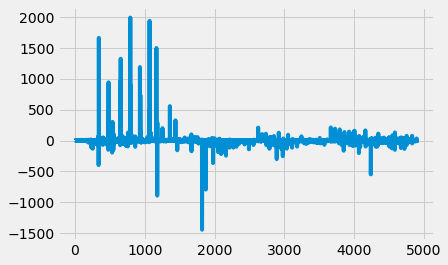

In [30]:
# Plot the difference between categories of 'CULEX PIPIENS/RESTUANS' 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS'
train_pivot['compare'].plot()

There doesnt seem to be systematic duplication of data. Only 287 rows out of 4897 or 6% had zero differences and non-zero mosquito counts. Hence we propose to leave the data as it is.

In [31]:
test.shape

(44550, 12)

In [32]:
traintest_processed = pd.concat([train_processing, test], axis=0, ignore_index=True)

In [33]:
traintest_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52854 entries, 0 to 52853
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dataset       52854 non-null  object        
 1   date          52854 non-null  datetime64[ns]
 2   species       52854 non-null  object        
 3   trap          52854 non-null  object        
 4   latitude      52854 non-null  float64       
 5   longitude     52854 non-null  float64       
 6   wnvpresent    8304 non-null   float64       
 7   year          52854 non-null  int64         
 8   month         52854 non-null  int64         
 9   week          52854 non-null  int64         
 10  dayofweek     52854 non-null  int64         
 11  nummosquitos  8304 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 4.8+ MB


In [34]:
traintest_processed['nummosquitos'].sum()

134370.0

### Export CSV

In [60]:
traintest_processed

,dataset,date,species,trap,latitude,longitude,wnvpresent,year,month,week,dayofweek,nummosquitos,geometry
0,train,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,0.0,2007,5,22,1,1.0,POINT (-87.67751 41.73192)
1,train,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0.0,2007,5,22,1,1.0,POINT (-87.80099 41.95469)
2,train,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0.0,2007,5,22,1,1.0,POINT (-87.82481 41.97409)
3,train,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0.0,2007,5,22,1,1.0,POINT (-87.65422 41.86711)
4,train,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,0.0,2007,5,22,1,1.0,POINT (-87.69426 41.91934)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52849,test,2014-10-02,CULEX RESTUANS,T094B,41.719140,-87.669539,NaN,2014,10,40,3,NaN,POINT (-87.66954 41.71914)
52850,test,2014-10-02,CULEX PIPIENS,T094B,41.719140,-87.669539,NaN,2014,10,40,3,NaN,POINT (-87.66954 41.71914)
52851,test,2014-10-02,CULEX PIPIENS/RESTUANS,T054C,41.925652,-87.633590,NaN,2014,10,40,3,NaN,POINT (-87.63359 41.92565)
52852,test,2014-10-02,CULEX RESTUANS,T054C,41.925652,-87.633590,NaN,2014,10,40,3,NaN,POINT (-87.63359 41.92565)


In [35]:
traintest_processed.to_csv('../data/processed_traintest.csv')

### Process Location Data for Trap location in Train & Test and Spray Locations

We would use Shapely and Geopandas packages to process and visualize location data

In [36]:
# Define Coordinate Reference System type
crs = {'init':'epsg:4326'}

In [37]:
# Trap Locations
# Create column of Shapely Point objects of the location of each trap
geometry = [Point(xy) for xy in zip(traintest_processed['longitude'], traintest_processed['latitude'])]
# Transform traintest into a GeoDataFrame
traintest_processed = gpd.GeoDataFrame(traintest_processed,
                         crs=crs,
                          geometry=geometry
                         )

In [38]:
# Spray Locations
# Create column of Shapely Point objects of the location of each spray
spray_location = [Point(xy) for xy in zip(spray['longitude'], spray['latitude'])]
# Transform traintest into a GeoDataFrame
spray = gpd.GeoDataFrame(spray,
                         crs=crs,
                          geometry=spray_location
                         )

In [39]:
# Weather Stations
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
stations = {'Latitude':[41.995,41.786], 'Longitude':[-87.933,-87.752]}

In [40]:
# Create column of Shapely Point objects of the location of each weather station
station_location = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]
# Transform to GeoDataFrame
stations = gpd.GeoDataFrame(stations,
                         crs=crs,
                          geometry=station_location
                         )

In [41]:
# import community and precinct map boundary files
community_map = gpd.read_file('../data/Boundaries - Community Areas (current)/geo_export_696264d7-9f06-473f-a0d2-238466734f0f.shp')
precinct_map = gpd.read_file('../data/Precincts (current)/geo_export_c00eb2b5-21d4-4f5f-be2b-399758f8fb18.shp')

### EDA

In [42]:
# Create masks for categorical and numerical features
category_columns = [key for key, val in traintest_processed.iteritems() 
                    if traintest_processed.dtypes[key] == 'object']
numerical_columns = [key for key, val in traintest.iteritems() 
                     if (traintest_processed.dtypes[key] == 'int64') or 
                     (traintest_processed.dtypes[key] == 'float64') or
                     (traintest_processed.dtypes[key] == 'datetime64[ns]')
                    ]
print(len(category_columns))
print(len(numerical_columns))

3
9


Histograms

Text(0.5, 1.1, 'Histograms of Numeric Features')

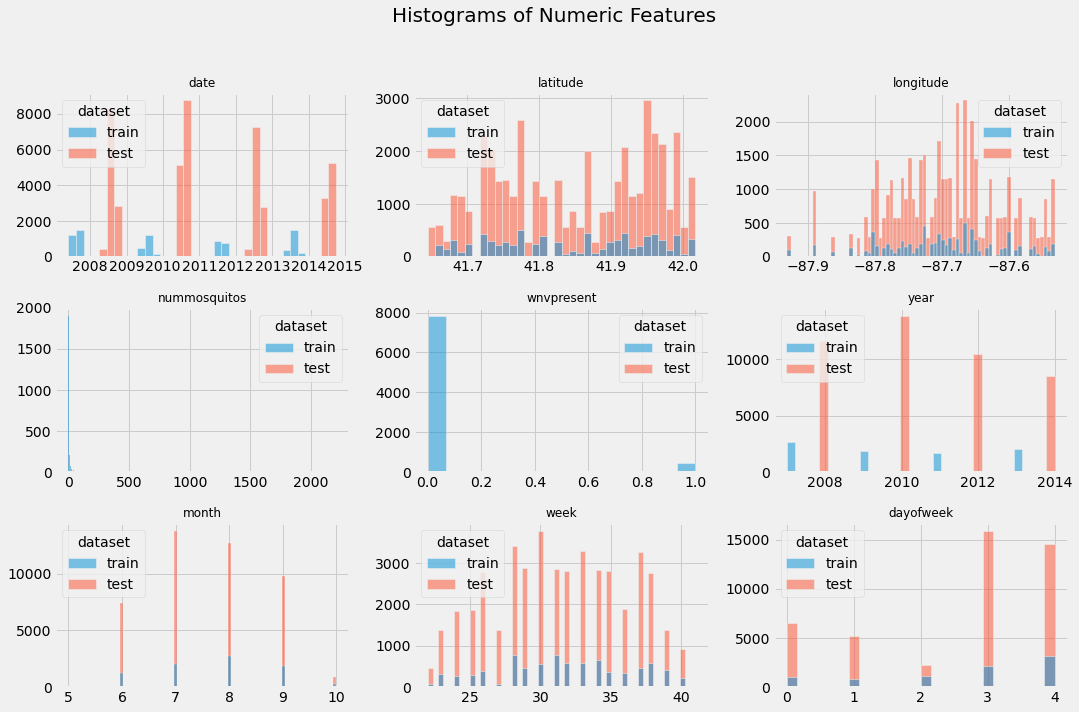

In [43]:
# Plot histograms of numeric features
cols = 3
rows = math.ceil(len(numerical_columns)/cols)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*3))
plt.tight_layout(h_pad=2, w_pad=2)

ax = ax.ravel()

for i, column in enumerate(numerical_columns):
    g = sns.histplot(data = traintest_processed, x=column, hue='dataset', ax=ax[i])
    ax[i].set_title(column,fontsize=12)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
fig.suptitle('Histograms of Numeric Features', 
             fontsize=20,y=1.1)  

Initial observations:
- Test data size is much larger than train data. 
- Date range is not continuous, train and test data fall under alternate years (i.e. train dataset only has data in the odd years e.g. 2007, 2009 while test dataset only has data in the even years e.g. 2008, 2010)

#### Date and Trap data

[Text(0.5, 1.0, 'Scatterplot of Traps(y-axis) against Time(x-axis) - Train & Test')]

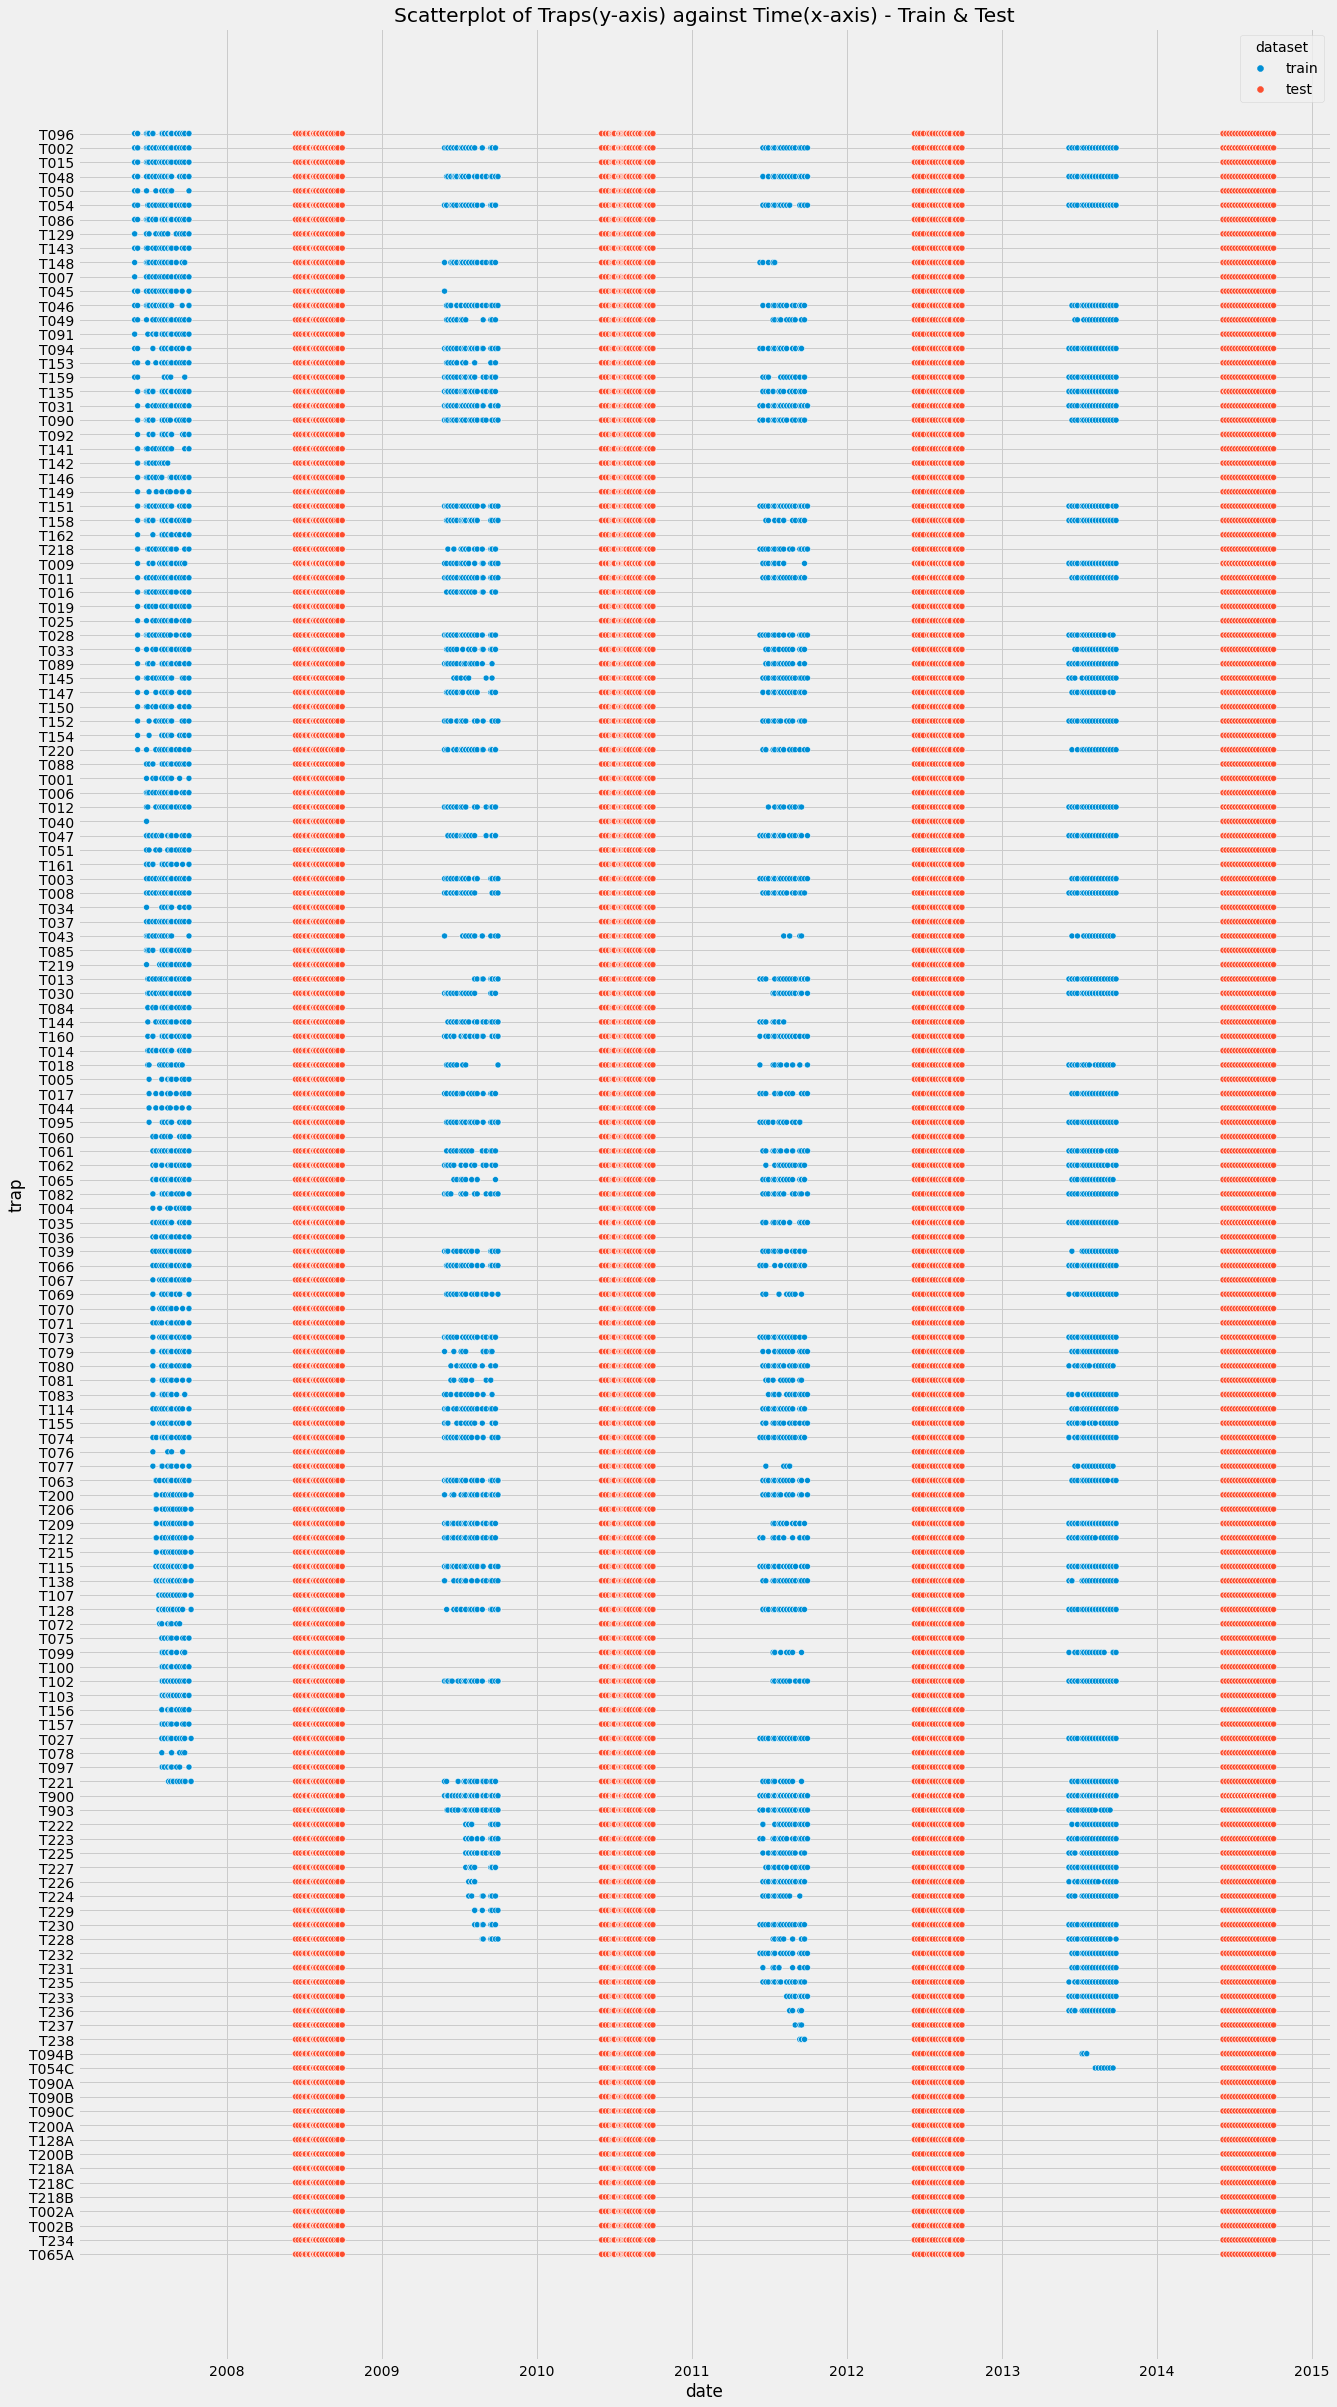

In [44]:
fig,ax = plt.subplots(figsize=(20,40))
sns.scatterplot(data=traintest_processed, x='date', y='trap', hue='dataset',) \
                .set(title= 'Scatterplot of Traps(y-axis) against Time(x-axis) - Train & Test')

Trap data is missing from train - There are 13 traps which are present in the test dataset which are not present in the train dataset

#### Date, Mosquito and WNVPresent

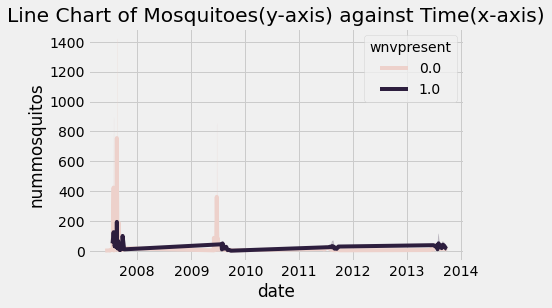

In [45]:
sns.lineplot(data=traintest_processed, x='date', y='nummosquitos', hue='wnvpresent',) \
                .set(title= 'Line Chart of Mosquitoes(y-axis) against Time(x-axis)');

- Number of mosquitoes typically surged around the mid of the year, as evident by the spikes in e.g. mid-2007, mid-2009.
- During this period, the occurrence of West Nile Virus also increased as evident by the spikes of black line in e.g. mid-2007, mid-2009
- In mid-2011 and mid-2013, the number of mosquitoes were fewer (i.e. less than 200). Corresponding, the occurrence of West Nile Virus was also fewer.
- Based on this, the number of mosquitoes and presence of West Nile Virus are likely to be strongly correlated.

[Text(0.5, 1.0, 'Line Chart of Mosquitoes(y-axis) by Week(x-axis)')]

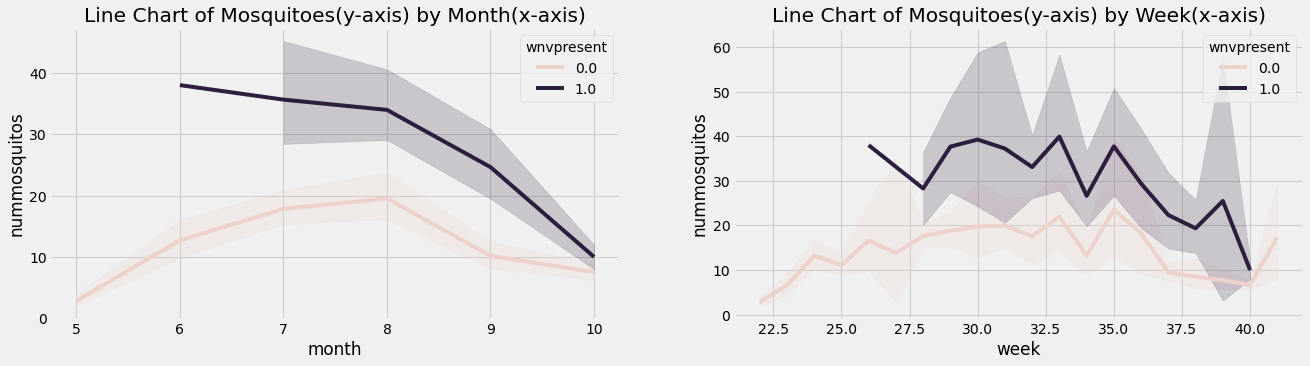

In [53]:
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
sns.lineplot(data=traintest_processed, x='month', y='nummosquitos', hue='wnvpresent',) \
                .set(title= 'Line Chart of Mosquitoes(y-axis) by Month(x-axis)')

plt.subplot(1, 2, 2)
sns.lineplot(data=traintest_processed, x='week', y='nummosquitos', hue='wnvpresent',) \
                .set(title= 'Line Chart of Mosquitoes(y-axis) by Week(x-axis)')

- The line graph for presence of West Nile Virus is consistently above the line for absence of West Nile Virus, further supporting that the number of mosquitoes and presence of West Nile Virus are likely to be strongly correlated
- Between Jun-Oct, the number of mosquitoes were the most between Jun-Aug. At locations without West Nile Virus, the number of mosquitoes increased since Jun and peaked in Aug while at locations with West Nile Virus, the number of mosquitoes declined slightly from Jun to Aug, suggesting that there could be some other features which affect the trajectory (e.g. spraying pesticide in these locations)

[Text(0.5, 1.0, 'Line Chart of Mosquitoes(y-axis) by Day of Month(x-axis)')]

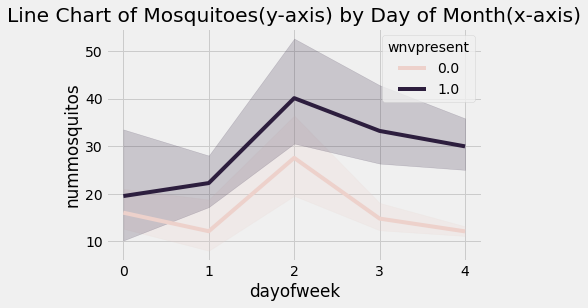

In [48]:
# Day of week = 0 (Monday), 1 (Tuesday), 2 (Wednesday), 3 (Thursday), 4 (Friday)
sns.lineplot(data=traintest_processed, x='dayofweek', y='nummosquitos', hue='wnvpresent',) \
                .set(title= 'Line Chart of Mosquitoes(y-axis) by Day of Month(x-axis)')

- For both lines (with or without West Nile Virus), the number of mosquitoes dipped on Thursday, which was the day when pesticide was typically sprayed.

#### Trap and spray locations

ImportError: The descartes package is required for plotting polygons in geopandas.

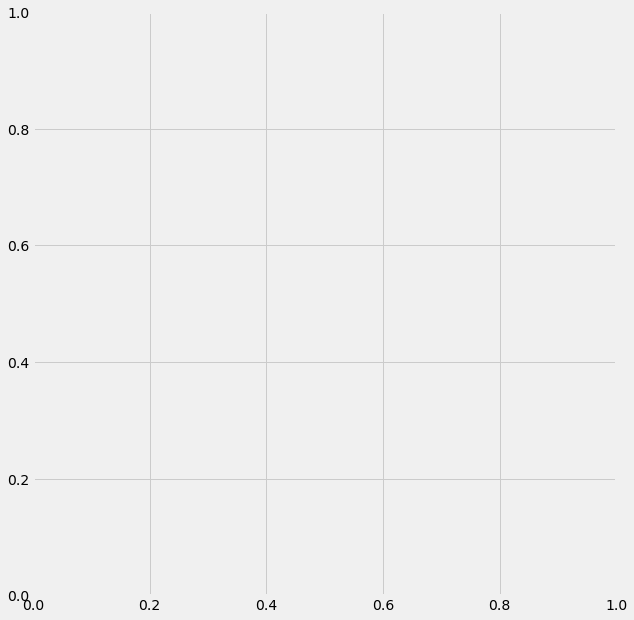

In [59]:
for date in list(spray['date'].value_counts().index):
    fig,ax = plt.subplots(figsize=(10,10))
    community_map.plot(ax=ax, alpha=0.4, color='grey',vmin=0, vmax=10,
                      edgecolor='blue'
                     )
    spray[spray['date']==date].plot(ax=ax, markersize=1, color='green', marker='o', label='spray')
    traintest_processed['geometry'].plot(ax=ax, markersize=1, color='red', marker='x', label='trap')
    stations['geometry'].plot(ax=ax, markersize=20, color='purple', marker='^', label='station')
    plt.title((f'Sprays conducted on {date}'))